In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
#import geopandas as gpd
import os
from shapely.geometry import Point, Polygon
#from geopandas import GeoDataFrame
from datetime import datetime
from datetime import timedelta

from sklearn.model_selection import GridSearchCV
from sklearn import neural_network
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_error

from sklearn import cluster
from sklearn.preprocessing import scale
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.decomposition import PCA

Using TensorFlow backend.


# Importing the dataset with all the variables generated up until now

In [2]:
reduced=pd.read_csv('reduced.csv')

In [3]:
targets=reduced[['Date','QTY','Unfulfilled orders','Daily Blood Donations']].groupby('Date').sum()

In [4]:
predictors=reduced[['Date','temp','feels_like','humidity',
                    'pressure','wind_speed','temp_max_min_diff','weekday_x','month','cl']].groupby('Date').agg(lambda x:x.value_counts().index[0])



In [5]:
consolidated=targets.merge(predictors, on='Date', how='left')

# Let's start with the implementation of the facebook prophet

In [6]:
consolidated.corr()

,QTY,Unfulfilled orders,Daily Blood Donations,temp,feels_like,humidity,pressure,wind_speed,temp_max_min_diff,weekday_x,month,cl
QTY,1.000000,0.938294,0.080993,0.167758,0.148024,-0.077733,-0.124060,0.007489,0.259284,0.077592,-0.066398,-0.196957
Unfulfilled orders,0.938294,1.000000,0.005593,0.165624,0.154367,-0.061080,-0.111907,-0.000943,0.235736,0.048912,-0.061645,-0.179553
Daily Blood Donations,0.080993,0.005593,1.000000,0.011523,0.014812,-0.000213,-0.018536,-0.013903,0.043728,0.069947,0.037218,-0.014871
temp,0.167758,0.165624,0.011523,1.000000,0.907789,-0.459712,-0.651478,-0.050406,0.369771,-0.020360,-0.344829,-0.069701
feels_like,0.148024,0.154367,0.014812,0.907789,1.000000,-0.107491,-0.592916,-0.273140,0.165988,-0.016573,-0.206245,-0.068073
humidity,-0.077733,-0.061080,-0.000213,-0.459712,-0.107491,1.000000,0.274045,0.029253,-0.678943,0.018968,0.311899,0.047284
pressure,-0.124060,-0.111907,-0.018536,-0.651478,-0.592916,0.274045,1.000000,-0.007418,-0.292971,-0.004005,0.219911,0.018192
wind_speed,0.007489,-0.000943,-0.013903,-0.050406,-0.273140,0.029253,-0.007418,1.000000,-0.191710,0.006886,-0.176572,0.053361
temp_max_min_diff,0.259284,0.235736,0.043728,0.369771,0.165988,-0.678943,-0.292971,-0.191710,1.000000,-0.001400,-0.164348,-0.040843
weekday_x,0.077592,0.048912,0.069947,-0.020360,-0.016573,0.018968,-0.004005,0.006886,-0.001400,1.000000,0.002506,0.020131


correlations are quite low, however we learnt from from the random foreset classifier that the variables cl,
temp_max_min_diff, weekday_y, and temp, feels_like, have a strong predictive power on the target variable; we 
can use them in the model

# Implementation of the Facebook Prophet

In [7]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

rescaling the continuous variables

In [8]:
#function to transfoms days codes in strings (so that can be re-encoded for the model)

def codes_to_daystrings(x):
    if x == 0:
        return 'Mon'
    if x == 1:
        return 'Tue'
    if x == 2:
        return 'Wed'
    if x == 3:
        return 'Thu'
    if x == 4:
        return 'Fri'
    if x ==5:
        return 'Sat'
    if x==6:
        return 'Sun'

In [9]:
consolidated['weekday_days']=consolidated['weekday_x'].apply(lambda i: codes_to_daystrings(i))

In [10]:
consolidated=consolidated.reset_index()

In [11]:
df = pd.DataFrame()
df['ds'] = pd.to_datetime(consolidated['Date']).dt.date
df['y'] = consolidated['QTY']
df['temp'] = consolidated['temp']
df['pressure'] = consolidated['pressure']
df['humidity'] = consolidated['wind_speed']
df['weendspeed'] = consolidated['humidity']
df['geocoding'] = consolidated['cl']
df['temp_max_min_diff'] = consolidated['temp_max_min_diff']

df = pd.concat([df, pd.get_dummies(consolidated['weekday_days'])], axis=1)
df['sma'] = consolidated['QTY'].rolling(window=30).mean()
df['sma2'] = consolidated['QTY'].rolling(window=100).mean()

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


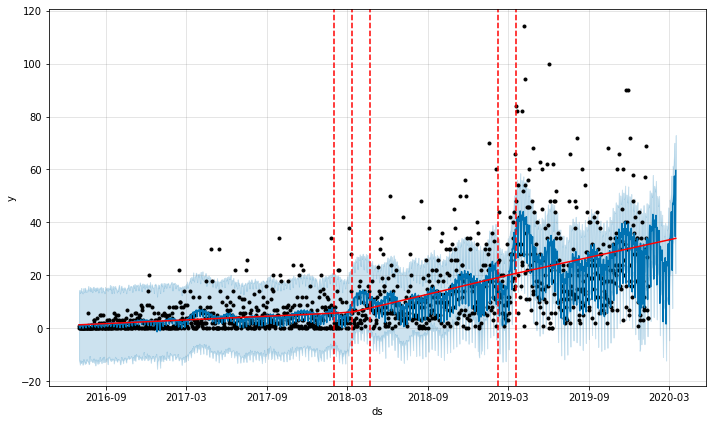

In [12]:
prophet = Prophet(growth='linear',
                  yearly_seasonality=True,
                  weekly_seasonality=True,
                  daily_seasonality=False,
                  seasonality_mode='multiplicative',
                  seasonality_prior_scale=10,
                  holidays_prior_scale=10,
                  changepoint_prior_scale=.05,
                  mcmc_samples=0
                 ).add_seasonality(name='yearly',
                                    period=365,
                                    fourier_order=3,
                                    prior_scale=10,
                                    mode='additive'
                  )

prophet.add_country_holidays(country_name='Nigeria')
# prophet.add_regressor('temp')
# prophet.add_regressor('pressure')
# prophet.add_regressor('humidity')
# prophet.add_regressor('weendspeed')
# prophet.add_regressor('geocoding')
# prophet.add_regressor('temp_max_min_diff')
# prophet.add_regressor('Mon')
# prophet.add_regressor('Tue')
# prophet.add_regressor('Wed')
# prophet.add_regressor('Thu')
# prophet.add_regressor('Fri')
# prophet.add_regressor('Sat')
# prophet.add_regressor('Sun')



last_date = '2020-01-15'
forecat_period= (df['ds'].max() - df['ds'][df['ds']==pd.to_datetime(last_date)].values[0]).days

prophet.fit(df[df['ds'] < pd.to_datetime(last_date)])
future = prophet.make_future_dataframe(periods=forecat_period+1, freq='D')
# future['temp'] = df['temp']
# future['pressure'] = df['pressure']
# future['humidity'] = df['humidity']
# future['weendspeed'] = df['weendspeed']
# future['geocoding'] = df['geocoding']
# future['temp_max_min_diff'] = df['temp_max_min_diff']
# future['Mon'] = df['Mon']
# future['Tue'] = df['Tue']
# future['Wed'] = df['Wed']
# future['Thu'] = df['Thu']
# future['Fri'] = df['Fri']
# future['Sat'] = df['Sat']
# future['Sun'] = df['Sun']




forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()

Prophet model: 14.111250577488187
Moving Average 1: 18.012947461548926
Moving Average 2: 18.142634678770197
Simple Mean: 18.023538657286128


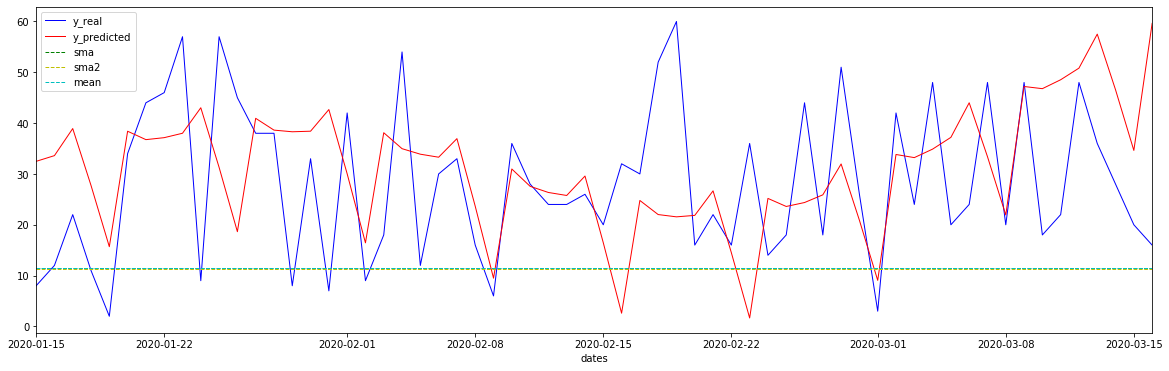

In [13]:
predictions=forecast[['ds','yhat']][forecast['ds'] >=pd.to_datetime(last_date)]
series_moving_averages = df[['ds','y','sma','sma2']][df['ds'] <pd.to_datetime(last_date)]
real= df[['ds','y']][df['ds'] >=pd.to_datetime(last_date)]

comparison=pd.DataFrame()
comparison['dates']= real['ds']
comparison['y_real']= real['y']
comparison['y_predicted'] = predictions['yhat']
comparison['y- y_pred']= comparison['y_real'] - comparison['y_predicted']
comparison['sma']= series_moving_averages['sma'].mean()
comparison['sma2']= series_moving_averages['sma2'].mean()
comparison['mean']= series_moving_averages['y'].mean()
comparison=comparison.set_index('dates')

print('Prophet model:',mean_absolute_error(comparison['y_real'], comparison['y_predicted']))
print('Moving Average 1:',mean_absolute_error(comparison['y_real'], comparison['sma']))
print('Moving Average 2:',mean_absolute_error(comparison['y_real'], comparison['sma2']))
print('Simple Mean:',mean_absolute_error(comparison['y_real'], comparison['mean']))

ax = comparison[['y_real', 'y_predicted','sma','sma2','mean']].plot(
    figsize=(20, 6), style=['b', 'r','g--','y--','c--'], lw=1)

# We can resample the dataset into weekly data and see whether the forecast improves

In [14]:
consolidated['Date']=pd.to_datetime(consolidated['Date'])

In [15]:
weekly_target=consolidated[['Date','QTY','Unfulfilled orders','Daily Blood Donations']]
weekly_predictors=consolidated[['Date','temp','pressure','humidity','wind_speed','temp_max_min_diff','cl']]

In [16]:
weekly_target_df=weekly_target.set_index('Date')
weekly_target_rein=weekly_target_df.resample('W').sum()
weeks_target=weekly_target_rein.reset_index()

In [17]:
weekly_predictors_df=weekly_predictors.set_index('Date')
weekly_predictors_rein=weekly_predictors_df.resample('W').agg(lambda x:x.value_counts().index[0])
weeks_predicts=weekly_predictors_rein.reset_index()

In [18]:
df = pd.DataFrame()
df['ds'] = pd.to_datetime(weeks_target['Date']).dt.date
df['y'] = weeks_target['QTY']
df['temp'] = weeks_predicts['temp']
df['pressure'] = weeks_predicts['pressure']
df['humidity'] = weeks_predicts['wind_speed']
df['weendspeed'] = weeks_predicts['humidity']
df['geocoding'] = weeks_predicts['cl']
df['temp_max_min_diff'] = weeks_predicts['temp_max_min_diff']


df['sma'] = weeks_target['QTY'].rolling(window=30).mean()
df['sma2'] = weeks_target['QTY'].rolling(window=100).mean()

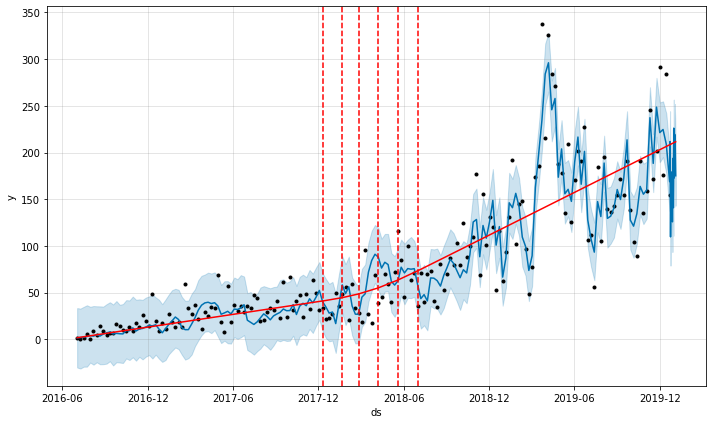

In [19]:
prophet = Prophet(growth='linear',
                  yearly_seasonality=True,
                  weekly_seasonality=False,
                  daily_seasonality=False,
                  seasonality_mode='multiplicative',
                  seasonality_prior_scale=10,
                  holidays_prior_scale=10,
                  changepoint_prior_scale=.05,
                  mcmc_samples=0
                 ).add_seasonality(name='yearly',
                                    period=365,
                                    fourier_order=3,
                                    prior_scale=10,
                                    mode='additive'
                  )

prophet.add_country_holidays(country_name='Nigeria')
prophet.add_regressor('temp')
prophet.add_regressor('pressure')
prophet.add_regressor('humidity')
prophet.add_regressor('weendspeed')
prophet.add_regressor('geocoding')
prophet.add_regressor('temp_max_min_diff')
# prophet.add_regressor('Mon')
# prophet.add_regressor('Tue')
# prophet.add_regressor('Wed')
# prophet.add_regressor('Thu')
# prophet.add_regressor('Fri')
# prophet.add_regressor('Sat')
# prophet.add_regressor('Sun')



prophet.fit(df.iloc[:-13,:])
future = prophet.make_future_dataframe(periods=13, freq='D')
future['temp'] = df['temp']
future['pressure'] = df['pressure']
future['humidity'] = df['humidity']
future['weendspeed'] = df['weendspeed']
future['geocoding'] = df['geocoding']
future['temp_max_min_diff'] = df['temp_max_min_diff']
# future['Mon'] = df['Mon']
# future['Tue'] = df['Tue']
# future['Wed'] = df['Wed']
# future['Thu'] = df['Thu']
# future['Fri'] = df['Fri']
# future['Sat'] = df['Sat']
# future['Sun'] = df['Sun']




forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()

Prophet model: 47.87406874387193
Moving Average 1: 108.08552036199094
Moving Average 2: 112.66255792400369
Simple Mean: 106.3182586644125


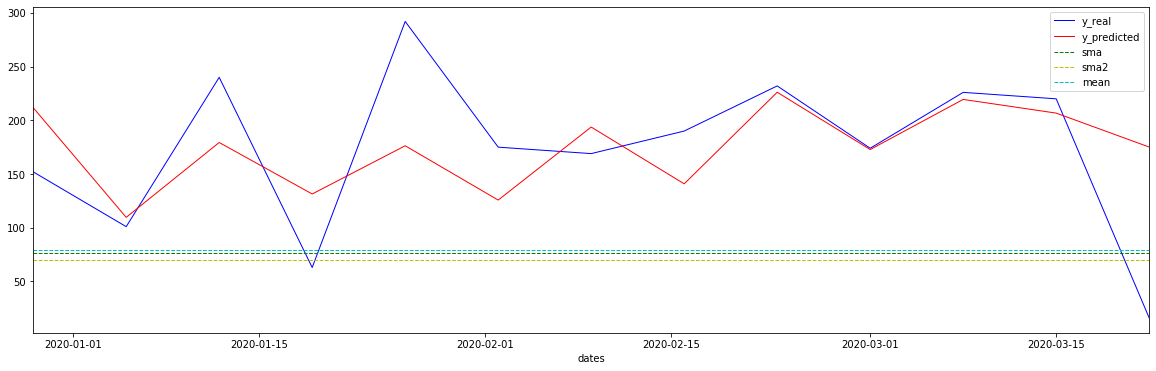

In [20]:
predictions=forecast[['ds','yhat']].iloc[-13:,:]
series_moving_averages = df[['ds','y','sma','sma2']].iloc[:-13,:]
real= df[['ds','y']].iloc[-13:,:]

comparison=pd.DataFrame()
comparison['dates']= real['ds']
comparison['y_real']= real['y']
comparison['y_predicted'] = predictions['yhat']
comparison['y- y_pred']= comparison['y_real'] - comparison['y_predicted']
comparison['% - off']= (comparison['y_predicted'] - comparison['y_real'])/comparison['y_real']
comparison['sma']= series_moving_averages['sma'].mean()
comparison['sma2']= series_moving_averages['sma2'].mean()
comparison['mean']= series_moving_averages['y'].mean()
comparison=comparison.set_index('dates')

print('Prophet model:',mean_absolute_error(comparison['y_real'], comparison['y_predicted']))
print('Moving Average 1:',mean_absolute_error(comparison['y_real'], comparison['sma']))
print('Moving Average 2:',mean_absolute_error(comparison['y_real'], comparison['sma2']))
print('Simple Mean:',mean_absolute_error(comparison['y_real'], comparison['mean']))

ax = comparison[['y_real', 'y_predicted','sma','sma2','mean']].plot(
    figsize=(20, 6), style=['b', 'r','g--','y--','c--'], lw=1)

# We can move with weekly forecasting for blood stock 

In [21]:
df = pd.DataFrame()
df['ds'] = pd.to_datetime(weeks_target['Date']).dt.date
df['y'] = weeks_target['Unfulfilled orders']
df['temp'] = weeks_predicts['temp']
df['pressure'] = weeks_predicts['pressure']
df['humidity'] = weeks_predicts['wind_speed']
df['weendspeed'] = weeks_predicts['humidity']
df['geocoding'] = weeks_predicts['cl']
df['temp_max_min_diff'] = weeks_predicts['temp_max_min_diff']


df['sma'] = weeks_target['Unfulfilled orders'].rolling(window=30).mean()
df['sma2'] = weeks_target['Unfulfilled orders'].rolling(window=100).mean()

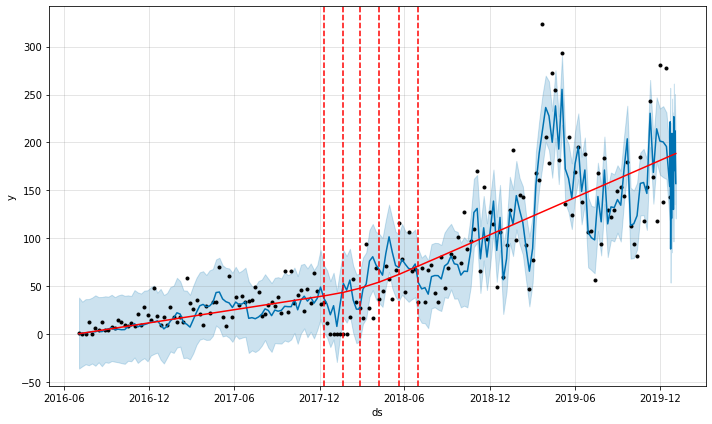

In [22]:
prophet = Prophet(growth='linear',
                  yearly_seasonality=True,
                  weekly_seasonality=False,
                  daily_seasonality=False,
                  seasonality_mode='multiplicative',
                  seasonality_prior_scale=10,
                  holidays_prior_scale=10,
                  changepoint_prior_scale=.05,
                  mcmc_samples=0
                 ).add_seasonality(name='yearly',
                                    period=365,
                                    fourier_order=3,
                                    prior_scale=10,
                                    mode='additive'
                  )

prophet.add_country_holidays(country_name='Nigeria')
prophet.add_regressor('temp')
prophet.add_regressor('pressure')
prophet.add_regressor('humidity')
prophet.add_regressor('weendspeed')
prophet.add_regressor('geocoding')
prophet.add_regressor('temp_max_min_diff')
# prophet.add_regressor('Mon')
# prophet.add_regressor('Tue')
# prophet.add_regressor('Wed')
# prophet.add_regressor('Thu')
# prophet.add_regressor('Fri')
# prophet.add_regressor('Sat')
# prophet.add_regressor('Sun')



prophet.fit(df.iloc[:-13,:])
future = prophet.make_future_dataframe(periods=13, freq='D')
future['temp'] = df['temp']
future['pressure'] = df['pressure']
future['humidity'] = df['humidity']
future['weendspeed'] = df['weendspeed']
future['geocoding'] = df['geocoding']
future['temp_max_min_diff'] = df['temp_max_min_diff']
# future['Mon'] = df['Mon']
# future['Tue'] = df['Tue']
# future['Wed'] = df['Wed']
# future['Thu'] = df['Thu']
# future['Fri'] = df['Fri']
# future['Sat'] = df['Sat']
# future['Sun'] = df['Sun']




forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()

Prophet model: 43.32278748097967
Moving Average 1: 99.86907993966815
Moving Average 2: 104.51744207599631
Simple Mean: 98.52451394759086


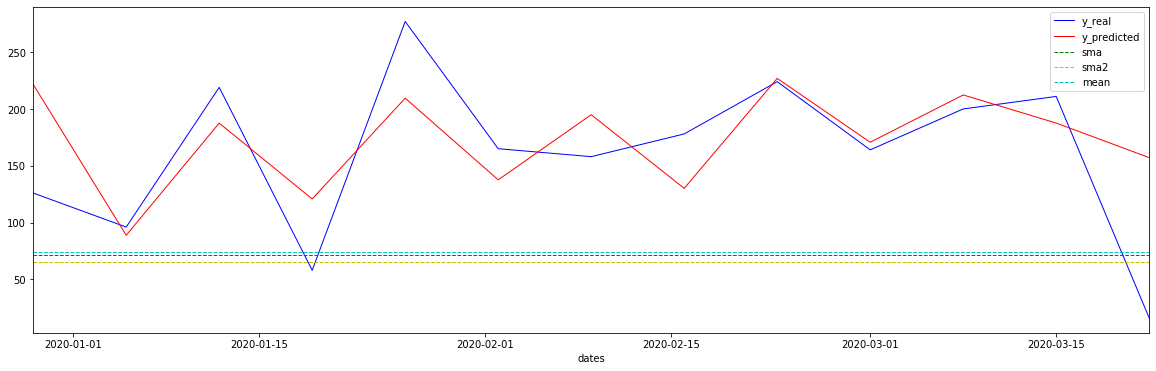

In [23]:
predictions=forecast[['ds','yhat']].iloc[-13:,:]
series_moving_averages = df[['ds','y','sma','sma2']].iloc[:-13,:]
real= df[['ds','y']].iloc[-13:,:]

comparison=pd.DataFrame()
comparison['dates']= real['ds']
comparison['y_real']= real['y']
comparison['y_predicted'] = predictions['yhat']
comparison['y- y_pred']= comparison['y_real'] - comparison['y_predicted']
comparison['% - off']= (comparison['y_predicted'] - comparison['y_real'])/comparison['y_real']
comparison['sma']= series_moving_averages['sma'].mean()
comparison['sma2']= series_moving_averages['sma2'].mean()
comparison['mean']= series_moving_averages['y'].mean()
comparison=comparison.set_index('dates')

print('Prophet model:',mean_absolute_error(comparison['y_real'], comparison['y_predicted']))
print('Moving Average 1:',mean_absolute_error(comparison['y_real'], comparison['sma']))
print('Moving Average 2:',mean_absolute_error(comparison['y_real'], comparison['sma2']))
print('Simple Mean:',mean_absolute_error(comparison['y_real'], comparison['mean']))

ax = comparison[['y_real', 'y_predicted','sma','sma2','mean']].plot(
    figsize=(20, 6), style=['b', 'r','g--','y--','c--'], lw=1)